## Import

In [4]:
import os
import numpy as np
import pandas as pd
from unidecode import unidecode
from matplotlib import pyplot as plt
from matplotlib import gridspec as gridspec
import seaborn as sns
from google.cloud import storage
import math
import requests
import bs4
import re
import ast


import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
pd.set_option('display.max_columns', 100)

## Funções

In [5]:
def get_data(bucket_name:str, imobiliarias:str = ['apolar', 'cilar'],by:str = ['date','date_diff'], dates:list = [], date_diff:int = 2):
    storage_client = storage.Client()
    bucket = storage_client.get_bucket(bucket_name)

    files_on_bucket = [i.name for i in bucket.list_blobs()]
    files = pd.DataFrame(files_on_bucket, columns=['name'])
    files['date'] = pd.to_datetime(files['name'].apply(lambda f: f.split(' - ')[0]))
    files['imobiliaria'] = files['name'].apply(lambda f: f.split(' - ')[-1].replace('.csv',''))

    match by:
        case 'date':
            files = files.loc[files['date'].isin(dates)]
            files = files.loc[files['imobiliaria'].isin(imobiliarias)]
        case 'date_diff':
            dates = files['date'].sort_values(ascending=False).drop_duplicates().reset_index(drop=True)[:date_diff].tolist()
            files = files.loc[files['date'].isin(dates)]
            files = files.loc[files['imobiliaria'].isin(imobiliarias)]
    
    df_full = pd.DataFrame()

    for file_name in files['name'].tolist():
        try:
            df_aux = pd.read_csv(f'gs://{bucket_name}/{file_name}')
            df_full = pd.concat([df_full, df_aux], axis = 0)
        except:
            pass

    df_full = df_full.reset_index(drop=True)

    return df_full

def get_all_dates(bucket_name):

    storage_client = storage.Client()
    bucket = storage_client.get_bucket(bucket_name)

    datas = set([i.name.split(' - ')[0] for i in bucket.list_blobs()])

    return datas

def histplot_matrix(data, columns,figsize=(10,6)):

    plt.figure(figsize=figsize)
    n_features = len(columns)

    rows = int(np.floor(np.sqrt(n_features)))
    cols = int(np.ceil(n_features/rows))

    grid = gridspec.GridSpec(rows,cols)

    for row in range(rows):
        for col in range(cols):
            try:
                n = (row*cols) + col
                column_name = columns[n]
                plt.subplot(grid[row,col])
                plt.title(column_name)
                sns.histplot(data[column_name])
            except:
                pass

    plt.tight_layout()

def get_infos_curitiba():

    ## Request site
    response = requests.get('https://pt.wikipedia.org/wiki/Lista_de_bairros_de_Curitiba')

    ## beautiful soup object
    soup = bs4.BeautifulSoup(response.content, 'html.parser')

    # tabelas da wikipedia
    infos_tabela = soup.findAll('table', {'class','wikitable'})

    bairros_info_list = []

    ## para cada tabela
    for tabela in infos_tabela:

        # colunas
        columns = [i.text.replace('\n','') for i in tabela.findAll('th')]

        # valores da tabela
        regiao = ' '.join([i.text.replace('\xa0','').replace('\n','') for i in tabela.findAll('td')][0].replace('Bairros oficiais de Curitiba - Regional ','').split(' ')[:-1])
        table_values = [i.text.replace('\xa0','').replace('\n','') for i in tabela.findAll('td')][1::]
        table_values_list = [] 
        for i in range(0,len(table_values),7): 
            table_values_list.append(table_values[i:i+7])

        # preenchenco dicionário
        for b in table_values_list:

            bairros_info_dict = {}
            bairros_info_dict['regiao'] = regiao
            bairros_info_dict['bairro'] = b[0]
            bairros_info_dict['area_bairro'] = b[1].replace(',','.')
            bairros_info_dict['qtd_homens'] = b[2].replace(',','.')
            bairros_info_dict['qtd_mulheres'] = b[3].replace(',','.')
            bairros_info_dict['total'] = b[4].replace(',','.')
            bairros_info_dict['qtd_domicilios_particulares'] = b[5].replace(',','.')
            bairros_info_dict['renda_media_responsaveis_domicilio'] = b[6].replace(',','.')

            bairros_info_list.append(bairros_info_dict)
    
    return pd.DataFrame(bairros_info_list)

def feature_engeniering(data, columns_selected):

    df = data.copy()

    df_aux = df.groupby('link').agg(data_min = ('data_coleta','min'), data_max=('data_coleta','max')).reset_index()
    df_aux['tempo_ate_locacao'] = (pd.to_datetime(df_aux['data_max']) - pd.to_datetime(df_aux['data_min'])).dt.days
    df_aux = df_aux.loc[df_aux['tempo_ate_locacao'] > 0]
    
    df = df[columns_selected].sort_values('data_coleta').drop_duplicates('link', keep = 'first')

    df_aux = pd.merge(df_aux, df, on = 'link', how = 'left')

    df_aux = df_aux[columns_selected + ['tempo_ate_locacao']]

    return df_aux

def barplot(group:str, 
            agg:str, 
            agg_name:str, 
            data:pd.DataFrame, 
            agg_func:str, 
            figure= plt.figure, 
            title_font_size:int =10, 
            figsize=(10,5),
            title:str='',
            subplot:plt.subplot = None, 
            grid:list = None, 
            orient:str='h',
            label=True,
            rotation_label:int = 45,
            position_label:str = 'center',
            color_label:str = 'white',
            size_label:str = 'small',
            fmt:str = '%.0f',
            sort: bool = True, 
            hue:str = None,
            stacked:bool = False):
    
    group_list = [group]
    if hue:
        group_list.append(hue)

    # group data
    aux = data[group_list + [agg]].groupby(group_list).agg(agg_func).reset_index().rename(columns={agg:agg_name})

    if sort:
        aux = aux.sort_values(agg_name, ascending=False)
        
    # plot
    if subplot:
        subplot(grid)
    else:
        figure(figsize=figsize)

    # plot configs
    plt.title(title, fontsize=title_font_size)
    plt.xticks(rotation = rotation_label)

    # figure
    if orient == 'h':
        g = sns.barplot(x = group, y = agg_name, hue = hue, dodge = not stacked, data = aux)
    elif orient == 'v':
        g = sns.barplot(y = group, x = agg_name, hue = hue, dodge = not stacked, data = aux)
    else:
        raise("Variável 'orient' informada não é válida")

    if label:
        for i in g.containers:
            g.bar_label(i, color = color_label, label_type=position_label, fontsize = size_label, fmt = fmt)
    else:
        pass

def tratamento_dados_cilar(data):

    df = data.copy()
    def formata_valores(valores):
        return valores.str.replace('.','').apply(lambda x: x if pd.isna(x) else x.split(',')[0]).astype('float64')

    def extrai_valores_string(string,substring):

        # Padronizar a expressão regular para encontrar a área total
        padrao = f'{substring} (\d+)'

        # Encontrar a área total usando regex
        area_total = re.search(padrao, string)

        if area_total:
            # Extrair o valor numérico da área total
            valor_area = area_total.group(1)
            
            # Remover vírgulas e converter para float
            valor_area = int(valor_area.replace(',', '.'))
            
        else:
            valor_area = np.nan
        
        return valor_area

    df['detalhes'] = df['detalhes'].apply(lambda x: x if pd.isna(x) else ast.literal_eval(x))
    df['detalhes'] = df['detalhes'].apply(lambda x: ' '.join(x).replace('Características do imóvel ','').strip() if isinstance(x,list) else x)

    # corrigindo alguns valores de iptu na coluna de condomínio
    df.loc[df['condominio'].str.contains('IPTU', na=False), 'iptu'] = df.loc[df['condominio'].str.contains('IPTU', na=False), 'condominio']
    df.loc[df['condominio'].str.contains('IPTU', na=False), 'condominio'] = np.nan

    df['aluguel'] = formata_valores(df['aluguel'].str.replace('AluguelR$','')).fillna(0)
    df['condominio'] = formata_valores(df['condominio'].str.replace('Condominio  R$','')).fillna(0)
    df['iptu'] = formata_valores(df['iptu'].str.replace('IPTU  R$','')).fillna(0)

    ## Detalhes do imóvel
    df['area'] = df['detalhes'].apply(lambda x: 0 if pd.isna(x) else extrai_valores_string(x,'Área Total')).fillna(0)
    df['quartos'] = df['detalhes'].apply(lambda x: 0 if  pd.isna(x) else extrai_valores_string(x,'Quartos')).fillna(0)
    df['suites'] = df['detalhes'].apply(lambda x: 0 if  pd.isna(x) else extrai_valores_string(x,'Suítes')).fillna(0)
    df['banheiros'] = df['detalhes'].apply(lambda x: 0 if  pd.isna(x) else extrai_valores_string(x,'Banheiros')).fillna(0)
    df['andar'] = df['detalhes'].apply(lambda x: 0 if  pd.isna(x) else extrai_valores_string(x,'Andar')).fillna(0)
    df['vagas_garagem'] = df['mais_detalhes_imovel'].apply(lambda x: 0 if  pd.isna(x) else extrai_valores_string(x,'Vagas de garagem:')).fillna(0)

    # Localidade
    df['bairro'] = df['endereco'].apply(lambda x: x if pd.isna(x) else unidecode(x.split(' - ')[-2].capitalize()))
    df['cidade'] = df['endereco'].apply(lambda x: x if pd.isna(x) else unidecode(x.split(' - ')[-1].capitalize()))

    # Atributos do imóvel e condomínio
    df['mobiliado'] = df['catacteristicas_imovel'].apply(lambda x: x if pd.isna(x) else 'Sim' if 'mobiliado' in unidecode(x.lower()) else 'Não')
    df['piscina'] = df['detalhes_condominio'].apply(lambda x: x if pd.isna(x) else 'Sim' if 'piscina' in unidecode(x.lower()) else 'Não')
    df['academia'] = df['detalhes_condominio'].apply(lambda x: x if pd.isna(x) else 'Sim' if 'academia' in unidecode(x.lower()) else 'Não')
    df['sacada'] = df['catacteristicas_imovel'].apply(lambda x: x if pd.isna(x) else 'Sim' if 'sacada' in unidecode(x.lower()) else 'Não')
    df['churrasqueira'] = df['detalhes_condominio'].apply(lambda x: x if pd.isna(x) else 'Sim' if 'churrasqueira' in unidecode(x.lower()) else 'Não')
    df['salao_de_festas'] = df['detalhes_condominio'].apply(lambda x: x if pd.isna(x) else 'Sim' if 'salao de festa' in unidecode(x.lower()) else 'Não')

    return df

def tratamento_dados_apolar(data):

    df = data.copy()
    def busca_substring(substring, string_list):
        result = np.nan
        for s in string_list:
            if substring in s:
                try:
                    result = re.findall(r'\s(\d{1,3}(?:[.,]\d{3})*(?:[.,]\d{2})?)', s)[0]
                except:
                    result = s
                break
                
        return result

    def separa_valores_imovel(string):

        # Padrao regex para encontrar nome e valor monetário
        padrao = r'(\w+)\sR\$\s(\d{1,3}(?:\.\d{3})*(?:,\d{2})?)'

        # Encontrar todas as correspondências na string
        correspondencias = re.findall(padrao, string)

        # Imprimir os resultados
        list_values = []
        for correspondencia in correspondencias:
            nome, valor = correspondencia
            list_values.append(f'{nome}: {valor}')
        
        return list_values

    def formata_valores(valores):
        return valores.str.strip().str.replace('.','').apply(lambda x: x if pd.isna(x) else x.split(',')[0]).astype('float64')

    df['titulo'] = df['titulo'].apply(lambda x: x if pd.isna(x) else x.replace('\n','').strip())
    df['endereco'] = df['endereco'].apply(lambda x: x if pd.isna(x) else x.replace('\n','').strip())
    df['descricao'] = df['descricao'].apply(lambda x: x if pd.isna(x) else x.replace('\n','').strip())

    df['bairro'] = df['endereco'].str.strip().apply(lambda x: x if pd.isna(x) else unidecode(x.replace('\n','').strip().split(', ')[-1].split(' - ')[0].capitalize()))
    df['cidade'] = df['endereco'].str.strip().apply(lambda x: x if pd.isna(x) else unidecode(x.replace('\n','').strip().split(', ')[-1].split(' - ')[-1].capitalize()))

    # Valores
    df['aluguel'] = df['valores'].apply(lambda x: x if pd.isna(x) else 
                        x.split(', ,')[0].replace('R$ ','').strip() if "Aluguel" not in x else
                        x.split(', ,')[0].replace('R$ ','').replace('Aluguel ','').strip() if "Aluguel" in x else
                        x)
    df['aluguel'] = df['aluguel'].apply(lambda x: x if pd.isna(x) else x.split(' ')[0])
    df['condominio'] = df['valores'].apply(lambda x: busca_substring('Condomínio', separa_valores_imovel(x)) if not pd.isna(x) else x)
    df['iptu'] = df['valores'].apply(lambda x: busca_substring('IPTU', separa_valores_imovel(x)) if not pd.isna(x) else x)
    df['seguro_incendio'] = df['valores'].apply(lambda x: busca_substring('Incêndio', separa_valores_imovel(x)) if not pd.isna(x) else x)

    # formatando valores
    df['aluguel'] = formata_valores(df['aluguel'])
    df['condominio'] = formata_valores(df['condominio']).fillna(0)
    df['iptu'] = formata_valores(df['iptu']).fillna(0)
    df['seguro_incendio'] = formata_valores(df['seguro_incendio']).fillna(0)

    # Atributos
    df['area'] = df['atributos'].apply(lambda x: x if pd.isna(x)  else busca_substring('m²', x.split(', '))).str.replace('m²','')
    df['banheiros'] = df['atributos'].apply(lambda x: x if pd.isna(x)  else busca_substring('banheiro', x.split(', '))).str.replace('banheiro','').str.replace('s','').fillna(0)
    df['quartos'] = df['atributos'].apply(lambda x: x if pd.isna(x)  else busca_substring('quarto', x.split(', '))).str.replace('quarto','').str.replace('s','').fillna(0)
    df['suites'] = df['atributos'].apply(lambda x: x if pd.isna(x)  else busca_substring('suite', x.split(', '))).str.replace('suite','').str.replace('s','').fillna(0)
    df['vagas_garagem'] = df['atributos'].apply(lambda x: x if pd.isna(x) else busca_substring('vagas', x.split(', '))).str.replace('vaga','').str.replace('s','').fillna(0)

    # Detalhes do imóvel/condomínio
    df['mobiliado'] = df['descricao'].apply(lambda x: np.nan if isinstance(x,float) else 'Sim' if 'mobiliado' in unidecode(x.lower()) else 'Não')
    df['piscina'] = df['descricao'].apply(lambda x: np.nan if isinstance(x,float) else 'Sim' if 'piscina' in unidecode(x.lower()) else 'Não')
    df['academia'] = df['descricao'].apply(lambda x: np.nan if isinstance(x,float) else 'Sim' if 'academia' in unidecode(x.lower()) else 'Não')
    df['sacada'] = df['descricao'].apply(lambda x: np.nan if isinstance(x,float) else 'Sim' if 'sacada' in unidecode(x.lower()) else 'Não')
    df['churrasqueira'] = df['descricao'].apply(lambda x: np.nan if isinstance(x,float) else 'Sim' if 'churrasqueira' in unidecode(x.lower()) else 'Não')
    df['salao_de_festas'] = df['descricao'].apply(lambda x: np.nan if isinstance(x,float) else 'Sim' if 'salao de festas' in unidecode(x.lower()) else 'Não')

    return df

def tratamento_dados_razao(data):

    df = data.copy()
    # 'titulo'
    df['titulo'] = df['titulo'].str.strip()

    # 'endereco'
    df['endereco'] = df['endereco'].str.strip()
    df['bairro'] = df['endereco'].apply(lambda x: x.split(' - ')[1])

    # 'condominio'
    df['condominio'] = df['condominio'].apply(lambda x: 0 if pd.isna(x) else np.nan if x == '' else x.replace('Cond. ','').replace('R$ ','').split(',')[0].replace('Sob consulta','0').replace(' ','')).fillna(0).astype('float64')

    # 'iptu'
    df['iptu'] = df['iptu'].apply(lambda x: x if pd.isna(x) else np.nan if x == '' else x.replace('IPTU  R$ ', '').split(',')[0]).fillna(0).astype('float64')

    # 'aluguel'
    df['aluguel'] = df['aluguel'].apply(lambda x: x.replace('R$ ','').replace('.','')).astype('float64')

    # 'itens_imovel'

    # 'descricao'

    df['atributos'] = df['atributos'].apply(lambda x: x if pd.isna(x) else ast.literal_eval(x))
    # formatando valores
    df['area'] = df['atributos'].apply(lambda x: x[4].split(' ')[0]).replace('(--)',0)
    df['quartos'] = df['atributos'].apply(lambda x: x[0]).replace('(--)',0)
    df['suites'] = df['atributos'].apply(lambda x: x[1]).replace('(--)',0)
    df['banheiros'] = df['atributos'].apply(lambda x: x[2]).replace('(--)',0)
    df['vagas_garagem'] = df['atributos'].apply(lambda x: x[3]).replace('(--)',0)

    return df

## Carregando Dados

In [6]:
bucket_name='busca-apartamentos-bucket'

datas = get_all_dates(bucket_name=bucket_name)

data_cilar = get_data(bucket_name='busca-apartamentos-bucket',by='date', dates=datas, imobiliarias=['cilar'])
data_apolar = get_data(bucket_name='busca-apartamentos-bucket',by='date', dates=datas, imobiliarias=['apolar'])
data_razao = get_data(bucket_name='busca-apartamentos-bucket',by='date', dates=datas, imobiliarias=['razao'])

_request non-retriable exception: HTTPSConnectionPool(host='oauth2.googleapis.com', port=443): Max retries exceeded with url: /token (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x788be25c8650>: Failed to resolve 'oauth2.googleapis.com' ([Errno -3] Temporary failure in name resolution)"))
Traceback (most recent call last):
  File "/home/arthur/anaconda3/envs/busca-apartamentos-env/lib/python3.11/site-packages/urllib3/connection.py", line 198, in _new_conn
    sock = connection.create_connection(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/anaconda3/envs/busca-apartamentos-env/lib/python3.11/site-packages/urllib3/util/connection.py", line 60, in create_connection
    for res in socket.getaddrinfo(host, port, family, socket.SOCK_STREAM):
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/arthur/anaconda3/envs/busca-apartamentos-env/lib/python3.11/socket.py", line 962, in getaddrinfo
    for res in _so

## Tratamento de Dados

### Tratando dados Raw

In [7]:
df_cilar_trusted = tratamento_dados_cilar(data_cilar)
df_apolar_trusted = tratamento_dados_apolar(data_apolar)
# df_razao_trusted = tratamento_dados_razao(data_razao)

In [8]:
df_cilar_trusted.columns

Index(['site', 'data_coleta', 'titulo', 'link', 'endereco', 'detalhes',
       'aluguel', 'condominio', 'iptu', 'catacteristicas_imovel',
       'detalhes_condominio', 'mais_detalhes_imovel', 'caracteristicas_imovel',
       'area', 'quartos', 'suites', 'banheiros', 'andar', 'vagas_garagem',
       'bairro', 'cidade', 'mobiliado', 'piscina', 'academia', 'sacada',
       'churrasqueira', 'salao_de_festas'],
      dtype='object')

### Reunindo em um único dataset

In [55]:
columns_selected = [
'site',
 'data_coleta',
 'titulo',
 'link',
 'endereco',
 'cidade',
 'bairro',
 'aluguel',
 'condominio',
 'iptu',
 'area',
 'quartos',
 'suites',
 'banheiros',
 'vagas_garagem',
 'mobiliado', 
 'piscina', 
 'academia', 
 'sacada',
 'churrasqueira', 
 'salao_de_festas'
]

df_full = pd.concat([df_cilar_trusted[columns_selected], df_apolar_trusted[columns_selected]], axis=0)
# df_full = pd.concat([df_full[columns_selected], df_razao_trusted[columns_selected]], axis=0)
df_full = df_full.loc[df_full['cidade'].str.lower() == 'curitiba']


In [56]:
# df_full = df_full.sort_values('data_coleta').drop_duplicates('link', keep = 'last')

### Valores Nulos

In [57]:
df_full.isna().sum()

site                   0
data_coleta            0
titulo                 0
link                   0
endereco               0
cidade                 0
bairro                 0
aluguel              369
condominio             0
iptu                   0
area                   0
quartos                0
suites                 0
banheiros              0
vagas_garagem          0
mobiliado          27621
piscina             4141
academia            4141
sacada             27621
churrasqueira       4141
salao_de_festas     4141
dtype: int64

In [58]:
# removendo erros no dataset

df_full = df_full.dropna(subset=['aluguel'])
df_full = df_full.dropna(subset=['endereco'])
df_full = df_full.dropna(subset=['area'])
df_full = df_full.fillna('Não')

### Tipos de Dados

In [59]:
df_full.dtypes

site                object
data_coleta         object
titulo              object
link                object
endereco            object
cidade              object
bairro              object
aluguel            float64
condominio         float64
iptu               float64
area                object
quartos             object
suites              object
banheiros           object
vagas_garagem       object
mobiliado           object
piscina             object
academia            object
sacada              object
churrasqueira       object
salao_de_festas     object
dtype: object

In [60]:
df_full['bairro'] = df_full['bairro'].str.strip().str.lower()
df_full['data_coleta'] = pd.to_datetime(df_full['data_coleta'])
df_full['area'] = df_full['area'].astype('float64')
df_full['quartos'] = df_full['quartos'].astype('int64')
df_full['suites'] = df_full['suites'].astype('int64')
df_full['banheiros']  = df_full['banheiros'].astype('int64')
df_full['vagas_garagem'] =  df_full['vagas_garagem'].astype('int64')

In [61]:
df_full.dtypes

site                       object
data_coleta        datetime64[ns]
titulo                     object
link                       object
endereco                   object
cidade                     object
bairro                     object
aluguel                   float64
condominio                float64
iptu                      float64
area                      float64
quartos                     int64
suites                      int64
banheiros                   int64
vagas_garagem               int64
mobiliado                  object
piscina                    object
academia                   object
sacada                     object
churrasqueira              object
salao_de_festas            object
dtype: object

## Análise Descritiva dos Dados

In [42]:
df_exp = df_full.copy()

sns.set_palette('muted')
LAYOUT_PALETTE = 'muted'

In [43]:
def histplot_matrix(data, columns,figsize=(10,6)):

    plt.figure(figsize=figsize)
    n_features = len(columns)

    rows = int(np.floor(np.sqrt(n_features)))
    cols = int(np.ceil(n_features/rows))

    grid = gridspec.GridSpec(rows,cols)

    for row in range(rows):
        for col in range(cols):
            try:
                n = (row*cols) + col
                column_name = columns[n]
                plt.subplot(grid[row,col])
                plt.title(column_name)
                sns.histplot(data[column_name])
            except:
                pass

    plt.tight_layout()

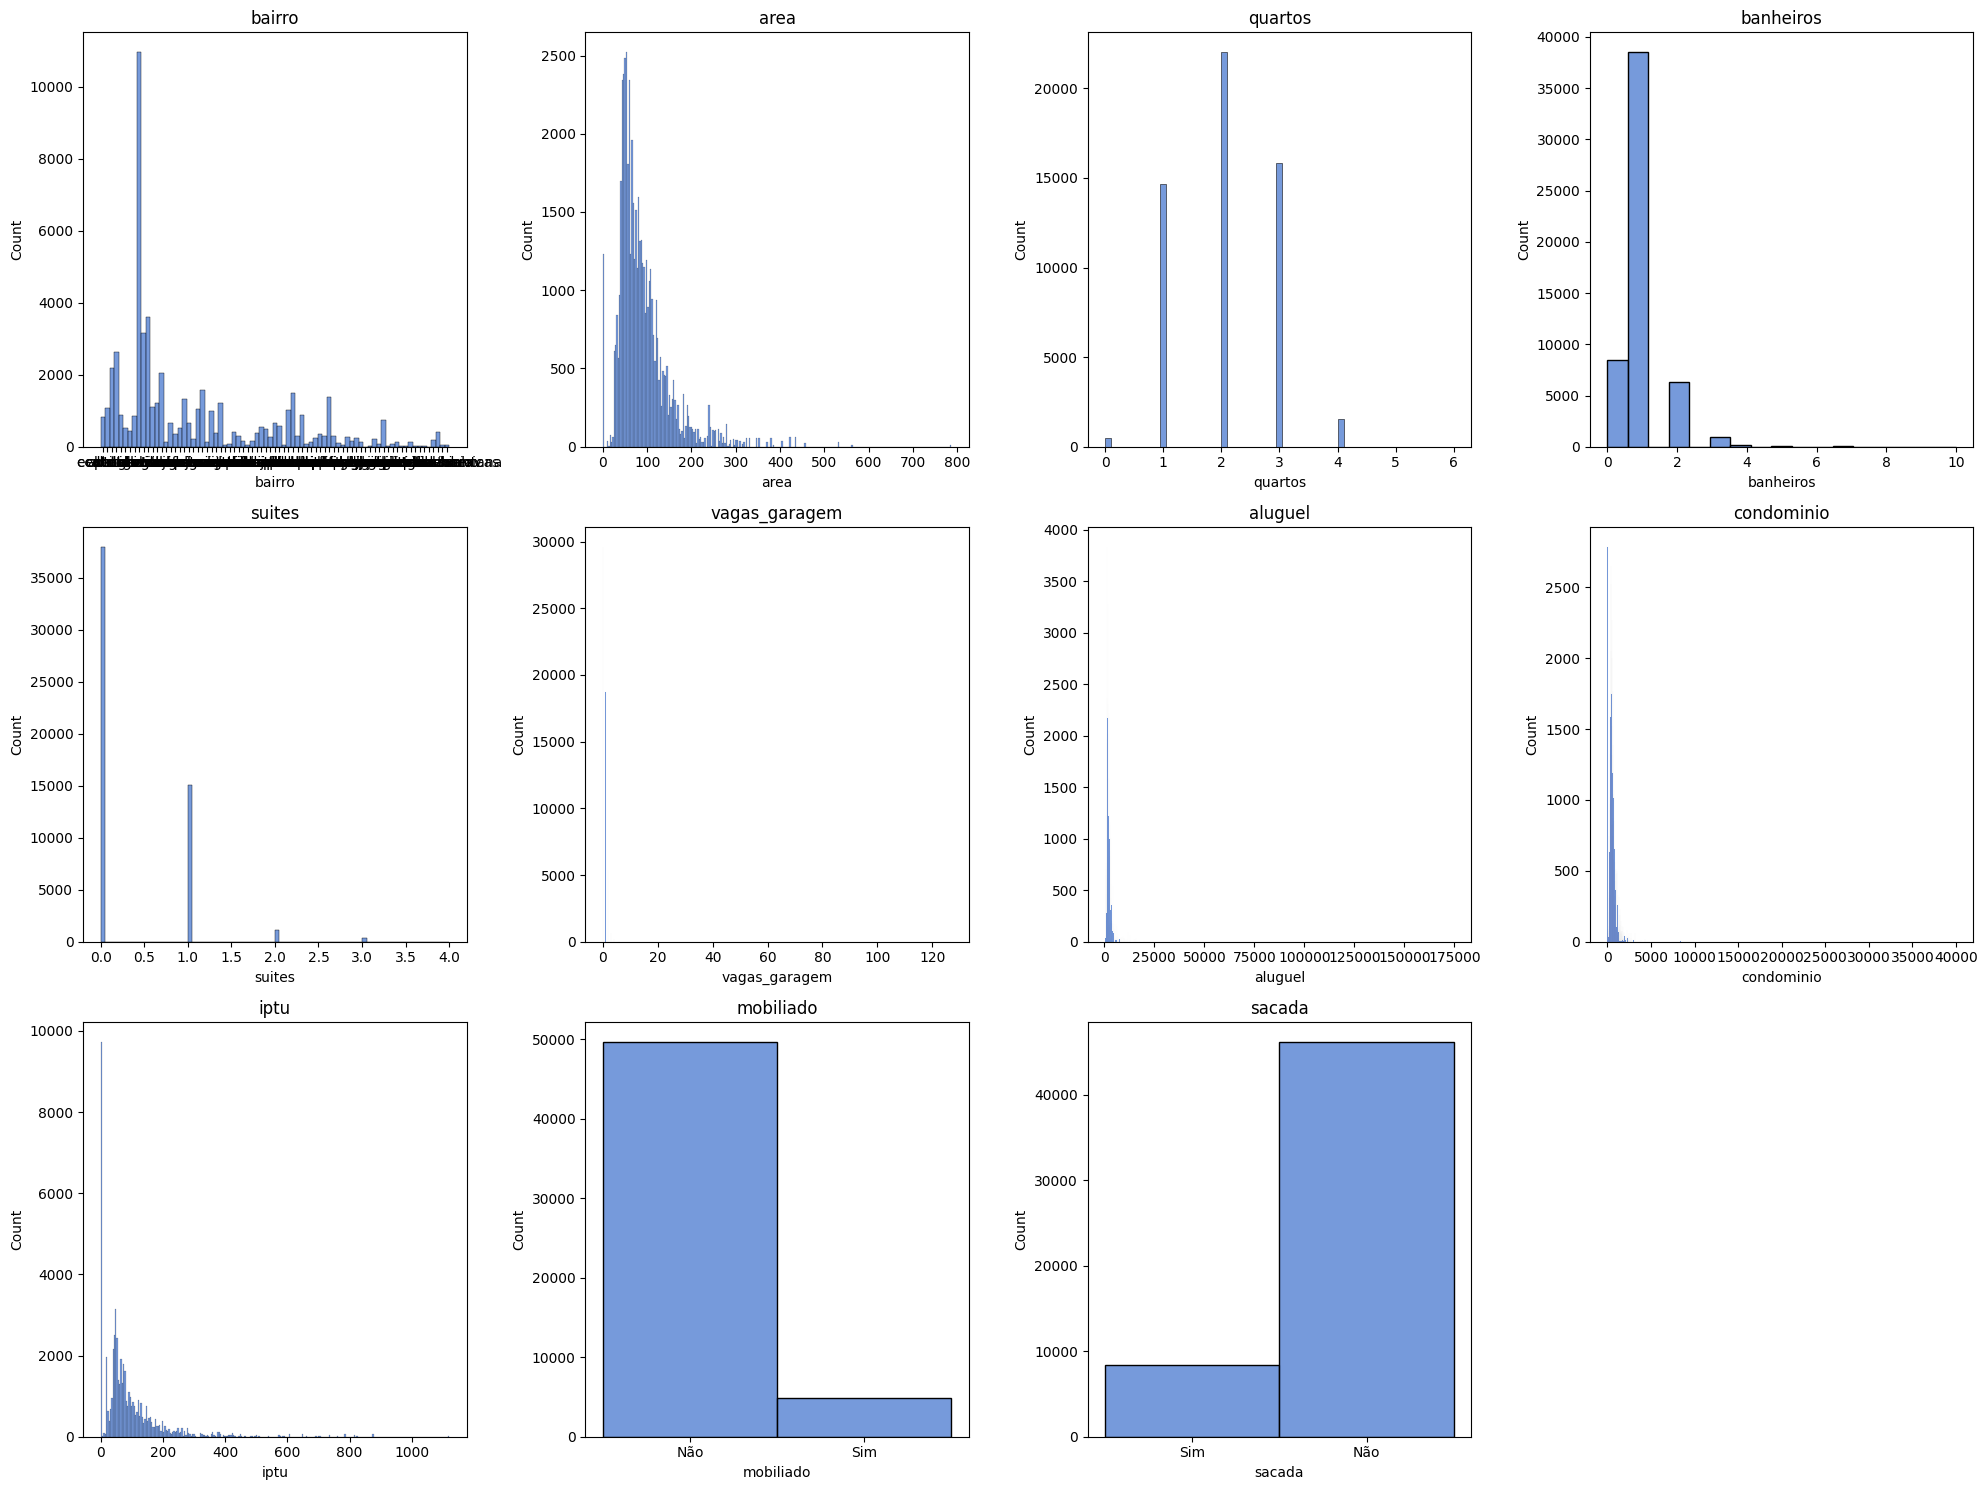

In [44]:
histplot_matrix(df_exp, ['bairro','area','quartos', 'banheiros', 'suites', 'vagas_garagem', 'aluguel','condominio','iptu', 'mobiliado','sacada'], figsize=(20,15))

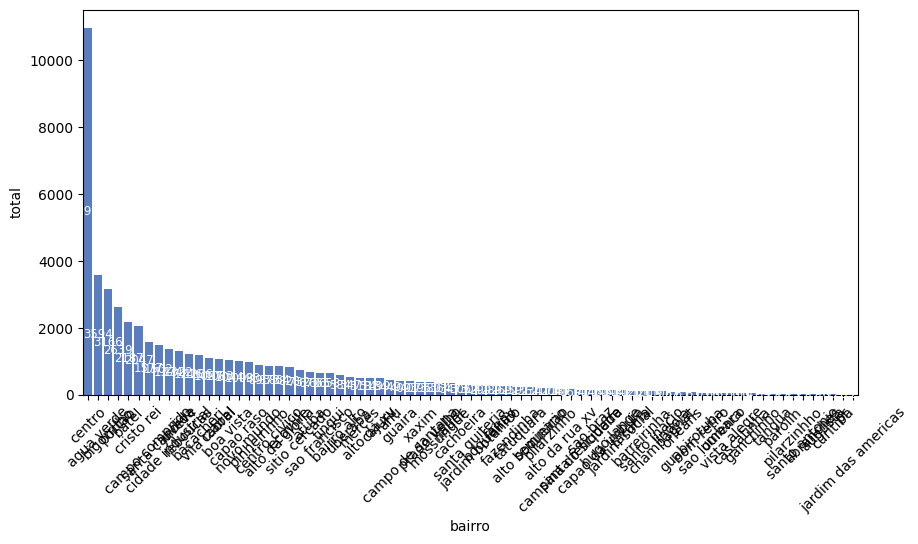

In [45]:
barplot(group='bairro', agg='link',agg_func='count',agg_name='total',data=df_full)

## Feature Engineering

In [62]:
df_full['valor_total'] = df_full['aluguel'] + df_full['condominio'] +  df_full['iptu'] 

In [63]:
ajustes = {
    'ecoville':'mossungue',
    'champagnat':'bigorrilho',
    'alto da rua xv': 'alto da xv',
    'novo mundo ': 'novo mundo',
    'jd. das americas': 'jardim das americas'
}

dados_curitiba = get_infos_curitiba()
dados_curitiba['bairro'] = dados_curitiba['bairro'].apply(lambda x: unidecode(x.lower()).strip())
dados_curitiba['bairro'] = dados_curitiba['bairro'].replace(ajustes)
dados_curitiba

,regiao,bairro,area_bairro,qtd_homens,qtd_mulheres,total,qtd_domicilios_particulares,renda_media_responsaveis_domicilio
0,Bairro Novo,ganchinho,11.20,3667,3658,7325,1921,767.35
1,Bairro Novo,sitio cercado,11.12,50631,51779,102410,27914,934.95
2,Bairro Novo,umbara,22.47,7280,7315,14595,17064,908.70
3,Boa Vista,abranches,4.32,5463,5702,11165,3154,1009.67
4,Boa Vista,atuba,4.27,6156,6476,12632,3627,1211.60
...,...,...,...,...,...,...,...,...
71,Santa Felicidade,santo inacio,2.72,2940,3097,6037,1683,1518.26
72,Santa Felicidade,sao braz,5.01,11163,11956,23119,6600,1206.50
73,Santa Felicidade,sao joao,3.03,1441,1509,2950,814,1166.03
74,Santa Felicidade,seminario,2.13,3350,4045,7395,2243,3210.65


In [64]:
df_full['bairro'] = df_full['bairro'].replace(ajustes)

df_full = pd.merge(df_full, dados_curitiba, on = 'bairro', how ='left')

df_full = df_full.dropna()

df_full['area_bairro'] = df_full['area_bairro'].astype('float64')
df_full['qtd_homens'] = df_full['qtd_homens'].astype('int64')
df_full['qtd_mulheres'] = df_full['qtd_mulheres'].astype('int64')
df_full['total'] = df_full['total'].astype('int64')
df_full['qtd_domicilios_particulares'] = df_full['qtd_domicilios_particulares'].astype('int64')
df_full['renda_media_responsaveis_domicilio'] = df_full['renda_media_responsaveis_domicilio'].astype('float64')


In [71]:
aux = df_full.groupby('link').agg(data_max=('data_coleta','max'), data_min=('data_coleta','min')).reset_index()
aux['dias_ate_locacao'] = (aux['data_max'] - aux['data_min']).dt.days

df_full = pd.merge(df_full, aux, on = 'link', how = 'left')

In [ ]:
df_full = df_full.sort_values('data_coleta').drop_duplicates('link', keep = 'last')

In [77]:
features_selected = [
'valor_total',
'area',
'quartos',
'suites',
'banheiros',
'vagas_garagem',
'mobiliado', 
'piscina', 
'academia',
'sacada', 
'churrasqueira', 
'salao_de_festas',
#  'qtd_homens',
#  'qtd_mulheres',
#  'total',
#  'qtd_domicilios_particulares',
#  'renda_media_responsaveis_domicilio'
]

In [78]:
X = df_full[features_selected].drop(columns=['valor_total'])
y = df_full['valor_total']

In [79]:
X = X.replace({'Sim':1,'Não':0})

In [80]:
X.head()

,area,quartos,suites,banheiros,vagas_garagem,mobiliado,piscina,academia,sacada,churrasqueira,salao_de_festas
34308,57.0,2,0,0,0,0,0,0,0,0,0
34201,116.0,3,1,2,0,0,0,0,1,0,0
34448,83.0,2,1,2,0,0,1,0,0,1,0
34455,40.0,1,0,0,0,0,0,0,0,0,0
34508,54.0,2,0,1,0,0,0,0,0,0,0


In [81]:
import statsmodels.api as sm

# Adicionando uma constante (intercepto)
X = sm.add_constant(X)

# Ajustando o modelo de regressão
model = sm.OLS(y, X)
results = model.fit()

# Exibindo os resultados
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            valor_total   R-squared:                       0.605
Model:                            OLS   Adj. R-squared:                  0.604
Method:                 Least Squares   F-statistic:                     660.2
Date:                Thu, 29 Aug 2024   Prob (F-statistic):               0.00
Time:                        20:29:27   Log-Likelihood:                -39173.
No. Observations:                4762   AIC:                         7.837e+04
Df Residuals:                    4750   BIC:                         7.845e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            1045.3262     40.266     

In [462]:
from sklearn import linear_model as lm
from sklearn import metrics as mt
from sklearn import model_selection as ms

# Selecionando colunas
X = df_full.drop(columns=['valor_total'])
y = df_full['valor_total']

# Divisão treino e teste
X_train_raw, X_test_raw, y_train_raw, y_test_raw = ms.train_test_split(X, y, test_size = 0.2)

data_train_raw = pd.concat([X_train_raw,y_train_raw],axis = 1)
data_test_raw = pd.concat([X_test_raw,y_test_raw],axis = 1)

print(f'Dataset de Treino: Linhas: {X_train_raw.shape[0]}, Colunas: {X_train_raw.shape[1]} ({round(X_train_raw.shape[0]/X.shape[0],1)*100}%)')
print(f'Dataset de Teste: Linhas: {X_test_raw.shape[0]}, Colunas: {X_test_raw.shape[1]} ({round(X_test_raw.shape[0]/X.shape[0],1)*100}%)')

Dataset de Treino: Linhas: 3924, Colunas: 28 (80.0%)
Dataset de Teste: Linhas: 982, Colunas: 28 (20.0%)


In [466]:
from sklearn import linear_model as lm
from sklearn import metrics as mt
from sklearn import model_selection as ms

def ml_error(model_name, y, yhat):
    mae = mt.mean_absolute_error(y,yhat)
    mape = mt.mean_absolute_percentage_error(y,yhat)
    rmse = np.sqrt(mt.mean_squared_error(y,yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                         'MAE': mae,
                         'MAPE':mape,
                         'RMSE':rmse},index=[0])

In [467]:
lm_model = lm.LinearRegression()

lm_model.fit(X_train_raw[features_selected],y_train_raw)

y_pred = lm_model.predict(X_train_raw[features_selected])

ml_error('Liner Regression', y_train_raw, y_pred)

KeyError: "['valor_total'] not in index"

In [26]:
X_train_raw[features_selected]

,valor_total,area,quartos,suites,banheiros,vagas_garagem
1724,4732.00,129.0,3.0,1.0,1.0,1.0
5322,1765.00,62.0,3.0,0.0,0.0,2.0
4240,1150.00,42.0,2.0,0.0,0.0,0.0
4565,1290.00,40.0,2.0,0.0,1.0,0.0
4895,2143.00,60.0,3.0,0.0,2.0,0.0
...,...,...,...,...,...,...
3646,3500.00,157.0,3.0,1.0,3.0,2.0
3055,2025.00,43.0,1.0,0.0,1.0,0.0
677,2900.00,139.0,3.0,0.0,2.0,1.0
3468,3376.82,112.0,3.0,0.0,1.0,1.0


In [ ]:
data_test_raw

,site,data_coleta,titulo,link,endereco,bairro,aluguel,condominio,iptu,area,quartos,suites,banheiros,vagas_garagem,valor_total,semanas_ate_locacao,tempo_ate_locacao,pred,erro
4869,Apolar,2024-03-07,Apartamento Residencial para Locação no Santa ...,https://www.apolar.com.br/alugar/curitiba/sant...,"Estrada Guilherme Weigert, 1725, Santa Cândida...",Santa candida,840.0,480.0,37.0,44.00,2.0,0.0,0.0,0.0,1357.0,9,61,30.044766,30.955234
4844,Apolar,2024-05-25,Apartamento Residencial para Locação no Santa ...,https://www.apolar.com.br/alugar/curitiba/sant...,"Rua Estêvão Manika, 420, Santa Cândida - Curitiba",Santa candida,800.0,460.0,41.0,52.00,2.0,0.0,1.0,0.0,1301.0,6,42,29.438208,12.561792
4950,Apolar,2024-02-21,Apartamento Residencial para Locação no Tatuqu...,https://www.apolar.com.br/alugar/curitiba/tatu...,"Rua Dilson Luiz, 1238, Tatuquara - Curitiba",Tatuquara,800.0,240.0,0.0,77.00,2.0,0.0,1.0,0.0,1040.0,25,178,30.449235,147.550765
114,Cilar,2024-03-19,Apartamento com 1 quarto,https://cilar.com.br/alugar/apartamento-com-1-...,"R BRIGADEIRO FRANCO, 2113 - CENTRO - Curitiba",Centro,1350.0,597.0,0.0,66.00,1.0,0.0,1.0,1.0,1947.0,1,7,31.725123,-24.725123
2121,Cilar,2024-02-21,Apartamento no 4º andar com 2 quartos,https://cilar.com.br/alugar/apartamento-no-4-a...,"R SILVEIRA PEIXOTO, 497 - BATEL - Curitiba",Batel,1700.0,736.0,96.0,73.00,2.0,0.0,1.0,0.0,2532.0,1,7,31.248507,-24.248507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3537,razao,2024-07-28,Apartamento no Agua Verde de 250.59 mAC com 4 ...,https://imobiliariarazao.com.br/ficha.php?url=...,"Avenida Presidente GetAslio Vargas, nAs 3163 -...",Agua verde,2800.0,1480.0,449.0,250.59,4.0,2.0,5.0,2.0,4729.0,1,6,33.374797,-27.374797
4458,Apolar,2024-05-18,Apartamento Residencial para Locação no Cristo...,https://www.apolar.com.br/alugar/curitiba/cris...,"Rua Cel. Pedro Scherer Sobrinho, 260, Cristo R...",Cristo rei,2660.0,652.0,0.0,75.00,2.0,0.0,1.0,0.0,3312.0,5,38,31.860112,6.139888
4212,Apolar,2024-08-10,Apartamento Residencial para Locação no Bairro...,https://www.apolar.com.br/alugar/curitiba/cent...,"Rua Tibagi, 779, Centro - Curitiba",Centro,1100.0,400.0,77.0,33.00,1.0,0.0,0.0,0.0,1577.0,1,7,30.366456,-23.366456
3385,razao,2024-07-28,Apartamento no Bigorrilho de 156 m2 com 3 quartos,https://imobiliariarazao.com.br/ficha.php?url=...,"Rua Euclides da Cunha, no 1560 - Bigorrilho - ...",Bigorrilho,3600.0,650.0,250.0,156.00,3.0,1.0,1.0,2.0,4500.0,3,20,35.008988,-15.008988


<Axes: xlabel='tempo_ate_locacao', ylabel='Density'>

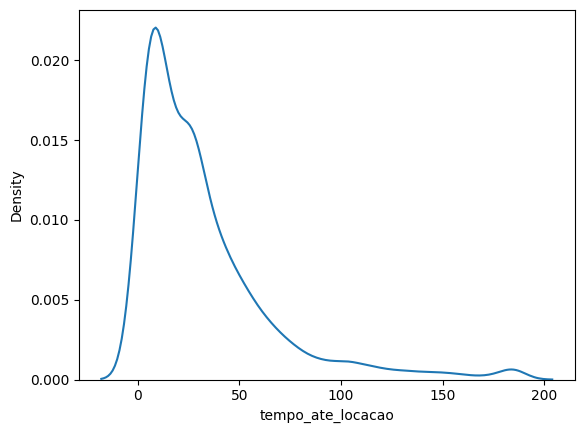

In [29]:
sns.kdeplot(data_train_raw['tempo_ate_locacao'])

<Axes: xlabel='tempo_ate_locacao', ylabel='Density'>

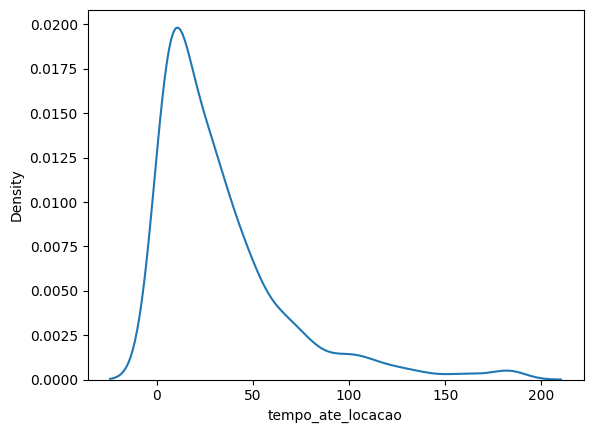

In [28]:
sns.kdeplot(data_test_raw['tempo_ate_locacao'])

In [495]:
data_test_raw

,site,data_coleta,titulo,link,endereco,bairro,aluguel,condominio,iptu,area,quartos,suites,banheiros,vagas_garagem,valor_total,semanas_ate_locacao,tempo_ate_locacao,pred
4869,Apolar,2024-03-07,Apartamento Residencial para Locação no Santa ...,https://www.apolar.com.br/alugar/curitiba/sant...,"Estrada Guilherme Weigert, 1725, Santa Cândida...",Santa candida,840.0,480.0,37.0,44.00,2.0,0.0,0.0,0.0,1357.0,9,61,30.044766
4844,Apolar,2024-05-25,Apartamento Residencial para Locação no Santa ...,https://www.apolar.com.br/alugar/curitiba/sant...,"Rua Estêvão Manika, 420, Santa Cândida - Curitiba",Santa candida,800.0,460.0,41.0,52.00,2.0,0.0,1.0,0.0,1301.0,6,42,29.438208
4950,Apolar,2024-02-21,Apartamento Residencial para Locação no Tatuqu...,https://www.apolar.com.br/alugar/curitiba/tatu...,"Rua Dilson Luiz, 1238, Tatuquara - Curitiba",Tatuquara,800.0,240.0,0.0,77.00,2.0,0.0,1.0,0.0,1040.0,25,178,30.449235
114,Cilar,2024-03-19,Apartamento com 1 quarto,https://cilar.com.br/alugar/apartamento-com-1-...,"R BRIGADEIRO FRANCO, 2113 - CENTRO - Curitiba",Centro,1350.0,597.0,0.0,66.00,1.0,0.0,1.0,1.0,1947.0,1,7,31.725123
2121,Cilar,2024-02-21,Apartamento no 4º andar com 2 quartos,https://cilar.com.br/alugar/apartamento-no-4-a...,"R SILVEIRA PEIXOTO, 497 - BATEL - Curitiba",Batel,1700.0,736.0,96.0,73.00,2.0,0.0,1.0,0.0,2532.0,1,7,31.248507
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3537,razao,2024-07-28,Apartamento no Agua Verde de 250.59 mAC com 4 ...,https://imobiliariarazao.com.br/ficha.php?url=...,"Avenida Presidente GetAslio Vargas, nAs 3163 -...",Agua verde,2800.0,1480.0,449.0,250.59,4.0,2.0,5.0,2.0,4729.0,1,6,33.374797
4458,Apolar,2024-05-18,Apartamento Residencial para Locação no Cristo...,https://www.apolar.com.br/alugar/curitiba/cris...,"Rua Cel. Pedro Scherer Sobrinho, 260, Cristo R...",Cristo rei,2660.0,652.0,0.0,75.00,2.0,0.0,1.0,0.0,3312.0,5,38,31.860112
4212,Apolar,2024-08-10,Apartamento Residencial para Locação no Bairro...,https://www.apolar.com.br/alugar/curitiba/cent...,"Rua Tibagi, 779, Centro - Curitiba",Centro,1100.0,400.0,77.0,33.00,1.0,0.0,0.0,0.0,1577.0,1,7,30.366456
3385,razao,2024-07-28,Apartamento no Bigorrilho de 156 m2 com 3 quartos,https://imobiliariarazao.com.br/ficha.php?url=...,"Rua Euclides da Cunha, no 1560 - Bigorrilho - ...",Bigorrilho,3600.0,650.0,250.0,156.00,3.0,1.0,1.0,2.0,4500.0,3,20,35.008988


In [485]:
data_test_raw.sample(10)

,site,data_coleta,titulo,link,endereco,bairro,aluguel,condominio,iptu,area,quartos,suites,banheiros,vagas_garagem,tempo_ate_locacao,valor_total,semanas_ate_locacao,pred,erro
5001,Apolar,2024-07-20,Apartamento Residencial para Locação no Bairro...,https://www.apolar.com.br/alugar/curitiba/uber...,"Rua Augusto Steembock, 492, Uberaba - Curitiba",Uberaba,1400.0,453.0,29.0,0.0,3.0,0.0,0.0,0.0,28,1882.0,4,3.977590,0.022410
4984,Apolar,2024-03-31,Apartamento Residencial para Locação no Uberab...,https://www.apolar.com.br/alugar/curitiba/uber...,"Rua Dalila Lopes Costa, 108, Uberaba - Curitiba",Uberaba,1100.0,600.0,20.0,58.0,3.0,0.0,1.0,0.0,34,1720.0,5,4.168093,0.831907
271,Cilar,2024-08-14,Apartamento com 2 quartos,https://cilar.com.br/alugar/apartamento-com-2-...,"Rua Santa Catarina, 612 - Água Verde - Curitiba",Agua verde,1500.0,367.0,0.0,97.0,2.0,0.0,1.0,1.0,3,1867.0,0,4.604570,-4.604570
1415,Cilar,2024-08-03,Apartamento no 2º andar com 1 quarto,https://cilar.com.br/alugar/apartamento-no-2-a...,"Rua Francisco Rocha, 1483 - Bigorrilho - Curitiba",Bigorrilho,1400.0,342.0,84.0,65.0,1.0,0.0,1.0,1.0,14,1826.0,2,4.495606,-2.495606
94,Cilar,2024-02-28,Apartamento com 1 quarto,https://cilar.com.br/alugar/apartamento-com-1-...,"Rua Saldanha Marinho, 825 - Centro - Curitiba",Centro,765.0,300.0,41.0,32.0,1.0,0.0,1.0,0.0,7,1106.0,1,4.146652,-3.146652
100,Cilar,2024-03-06,Apartamento com 1 quarto,https://cilar.com.br/alugar/apartamento-com-1-...,"R Amintas de Barros, 164 - Centro - Curitiba",Centro,1180.0,400.0,0.0,25.0,1.0,0.0,1.0,0.0,8,1580.0,1,4.145650,-3.145650
1658,Cilar,2024-07-09,Apartamento no 2º andar com 3 quartos,https://cilar.com.br/alugar/apartamento-no-2-a...,"Av Sete de Setembro, 3464 - Centro - Curitiba",Centro,2200.0,179.0,83.0,60.0,3.0,0.0,1.0,0.0,21,2462.0,3,4.250504,-1.250504
1914,Cilar,2024-07-20,Apartamento no 3º andar com 2 quartos,https://cilar.com.br/alugar/apartamento-no-3-a...,"Rua José Breda Sobrinho, 65 - Pinheirinho - Cu...",Pinheirinho,1700.0,400.0,54.0,67.0,2.0,0.0,1.0,1.0,17,2154.0,2,4.437000,-2.437000
1750,Cilar,2024-08-14,Apartamento no 24º andar com 1 quarto,https://cilar.com.br/alugar/apartamento-no-24-...,"Av Visconde de Guarapuava, 2764 - Centro - Cur...",Centro,2000.0,425.0,56.0,50.0,1.0,0.0,1.0,0.0,3,2481.0,0,4.392008,-4.392008
1954,Cilar,2024-07-02,Apartamento no 3º andar com 3 quartos,https://cilar.com.br/alugar/apartamento-no-3-a...,"Rua Guilherme Pugsley, 2655 - Água Verde - Cur...",Agua verde,1900.0,250.0,93.0,101.0,3.0,0.0,1.0,1.0,43,2243.0,6,4.563419,1.436581


In [496]:
data_test_raw['erro'] = data_test_raw['tempo_ate_locacao'] - data_test_raw['pred']

<Axes: ylabel='erro'>

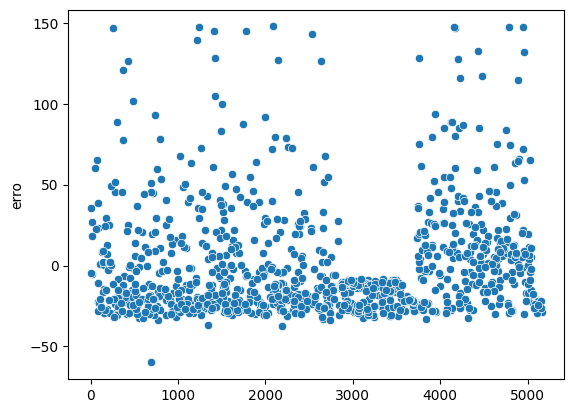

In [497]:
sns.scatterplot(data_test_raw['erro'])